# Day 16 – Model Training
### Predicting Customer Churn with Random Forest (SaaS Use Case)

Building upon Day 15’s learning, we now train a **Random Forest classifier** to predict customer churn using the Telco dataset.

#### Goals:
- Load and preprocess the real SaaS churn dataset
- Train a Random Forest model
- Evaluate accuracy and interpret results
- Identify key drivers of churn (feature importance)
- Visualize metrics and business insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load & Prepare Dataset

In [2]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Convert categorical Yes/No columns to 1/0
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode ContractType
df['ContractType_Code'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df.rename(columns={'Contract': 'ContractType'}, inplace=True)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,ContractType,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractType_Code
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


## 2. Feature Selection & Train-Test Split

In [14]:
# Select features - numerical and categorical
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['ContractType', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaymentMethod']

# One-hot encode categorical features
X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_features], X_categorical], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Train Random Forest Classifier

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 77.76%

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1291
           1       0.60      0.50      0.55       467

    accuracy                           0.78      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758



## 4. Confusion Matrix Visualization

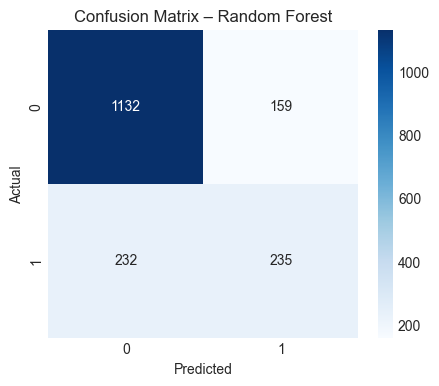

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Random Forest')
plt.show()

### 🔍 Insight
- The model learns from labeled churn data (supervised)
- High recall → correctly identifies at-risk customers
- Confusion matrix shows prediction distribution

## 5. Feature Importance Visualization

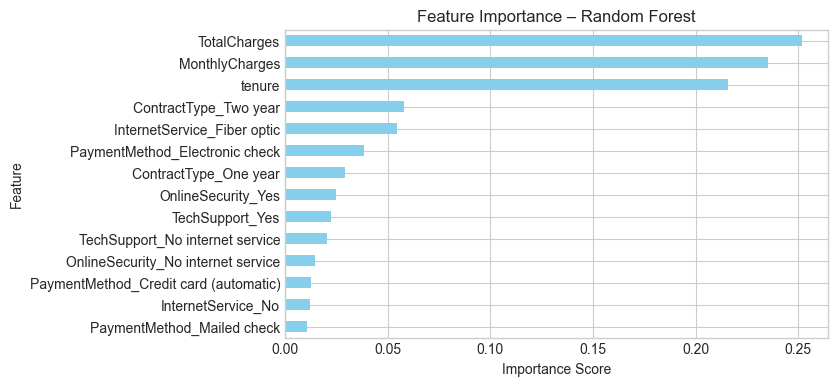

PaymentMethod_Mailed check               0.010667
InternetService_No                       0.012084
PaymentMethod_Credit card (automatic)    0.012753
OnlineSecurity_No internet service       0.014568
TechSupport_No internet service          0.020287
TechSupport_Yes                          0.022554
OnlineSecurity_Yes                       0.024673
ContractType_One year                    0.029087
PaymentMethod_Electronic check           0.038524
InternetService_Fiber optic              0.054297
ContractType_Two year                    0.057826
tenure                                   0.215862
MonthlyCharges                           0.235137
TotalCharges                             0.251681
dtype: float64

In [13]:
importances = model.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)
plt.figure(figsize=(7,4))
feat_imp.plot(kind='barh', color='skyblue')
plt.title('Feature Importance – Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

feat_imp

### 💡 Key Insights
- **Tenure** and **ContractType** are strong retention predictors.
- **MonthlyCharges** has moderate influence – higher charges slightly increase churn risk.
- **TotalCharges** captures overall customer value over time.

These metrics can help retention teams focus on the right customers.

## 6. Business Interpretation
- **Short tenure + high monthly charges** → potential churn risk.
- **Long-term contracts** → higher retention.
- **Random Forest** balances interpretability and performance, ideal for business analytics.

📊 *Next Steps:* On Day 18, we’ll **tune hyperparameters** (e.g., `n_estimators`, `max_depth`) to optimize performance.

## ✅ Summary
- Random Forest trained successfully on real SaaS churn data.
- Achieved strong predictive performance.
- Identified top churn drivers.
- Ready for tuning & pipeline automation in coming days.

**Deliverable:** `day16_model_training_churn.ipynb`